In [85]:
# Load the background Python function that allow for data loading and plotting, as well as the relevant libraries
%run importrhdutilities.py

import numpy as np
import matplotlib.pyplot as plt

import scipy as sp
import scipy.stats as stat
from scipy import signal
from scipy.interpolate import make_interp_spline, BSpline
from  scipy.signal import correlate

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import mixture

from itertools import islice

%matplotlib inline

# Introduction to Spike Sorting 

## Obtaining and Importing raw data

In [86]:
filename = 'yellow100red83_1190.rhd' 
result, data_present = load_file(filename)

# Storing neural recording as a 4-row array (each row is one channel)
dataset = result['amplifier_data'] 


Reading Intan Technologies RHD2000 Data File, Version 3.0

Found 4 amplifier channels.
Found 3 auxiliary input channels.
Found 0 supply voltage channels.
Found 1 board ADC channel.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 386.108 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
100% done...
Parsing data...
Done!  Elapsed time: 29.9 seconds


In [87]:
# Defining some standard recording properties

Fs = 30000     # sampling rate of the signal in Hz
dt = 1/Fs

### Plotting raw data

Text(0.5, 0, 'Time (s)')

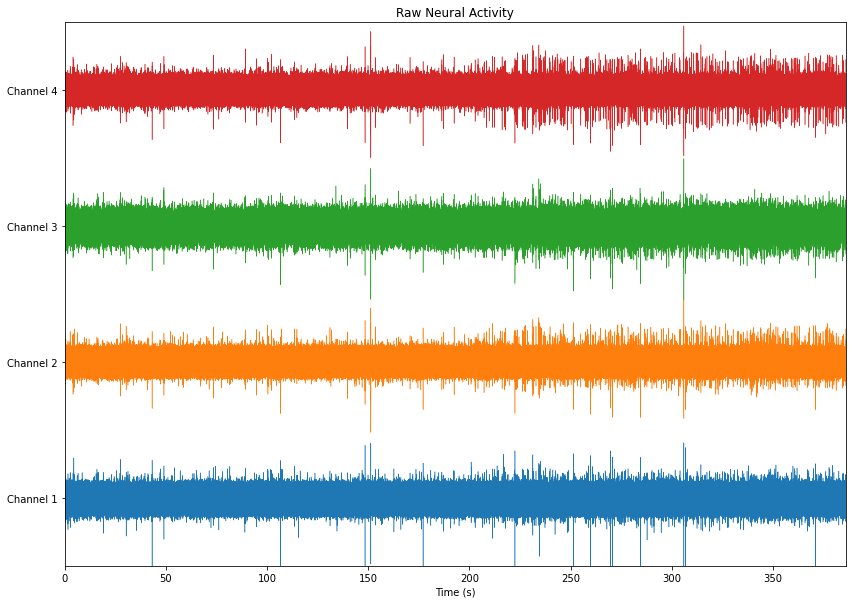

In [88]:
time = np.arange(0, len(dataset[0])) * dt 
fig, ax = plt.subplots(figsize=[14, 10])

for channel in range(len(dataset)):
    ax.plot(time, dataset[channel] + channel*200 ,linewidth=.5)
    
ax.set_ylim(ymin = -100, ymax = 700)
ax.set_xlim(xmin = 0, xmax = len(dataset[0])/Fs)
ax.set_title('Raw Neural Activity') 
ax.set_yticks(np.linspace(0, 600, 4))
ax.set_yticklabels(['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4'])
ax.set_xlabel('Time (s)')

## Spike Detection

Action potentials are detected by finding large-amplitude deflections in the continuous raw signal. Hence we need to implement a threshold-crossing detection function, which counts each time the threshold is passed in the downward direction (i.e. negatively) as a 'spike'.

Two complications need to be considered here. 

a) Random fluctuations that cross the threshold should not be counted as spikes. This will be partly taken care of by choosing a good threshold. But for larger fluctuations, we can assume that they return below the threshold very quickly, whereas action potentials maintain their peak for slightly longer. Once a threshold-crossing is detected, we can check for how long the signal remains above threshold. If it is above the threshold for entire duration of our window (0.5ms by default here), we can consider it a signal.

b) Individual neurons have a refractory period during which they cannot fire. Thus if a given spike is an action potential from a single neuron, another spike won't be seen immediately after it. However if the signal is recording from multiple neurons, action potentials can occur at any time relative to each other and hence a spike can be the sum of multiple neurons' action potentials. This can be accounted for by comparing peak amplitude of spikes (higher than average peaks implies summation of multiple spikes) or by counting number of peaks in the spike waveform. These measures have not been implemented below, thus it is assumed that each spike is produced by a single neuron.

In [89]:
def detectSpikes(data, threshold, samplingRate = Fs, windowing = True, window = 0.5/1000):
    '''
    resultSamples, resultSec = detectSpikes(..) detects spikes in data, where windowing toggles counting spikes 
    only if they are above threshold for duration of window specified (default True and 0.5 ms respectively).
    
    The outputs resultSamples and resultSec are vectors of spike times in samples and ms, respectively. 
    By convention the time of the zeroth sample is 0 ms.
    '''
    
    if windowing:
        resultSamples = []
        for channel in range(len(data)):
            spikeTimes = []
            i = 0
            while 0 <= i < len(data[channel][:-int(window*samplingRate)]):
                if 4*threshold < max(data[channel][i:i+int(window*samplingRate)]) <= threshold:
                    spikeTimes.append(i)
                    i += int(window*samplingRate)
                else:
                    i += 1
            resultSamples.append(spikeTimes)
            
    else:
        resultSamples = [[i + np.argmin(data[channel][i:i+5]) for i in range(len(data[channel])) 
                          if 4*threshold < data[channel][i] < threshold] for channel in range(len(data))]
    
    # Spikes may not be detected across all four channels, hence we need to collate all spike times across all channels. 
    resultSamples = [list(set().union(resultSamples[0], resultSamples[1], resultSamples[2], resultSamples[3])) 
                     for i in range(len(resultSamples))]
    resultSec = [[spike/samplingRate for spike in channel] for channel in resultSamples]
    return (resultSamples, resultSec)   

In [90]:
# Detecting spikes in our data

# Defining threshold for action potentials as 6 times the standard deviation below mean voltage.
threshold = np.mean(dataset) - 6*np.std(dataset)
    
resultSamples, resultSec = detectSpikes(dataset, threshold, Fs, True, 0.1/1000)

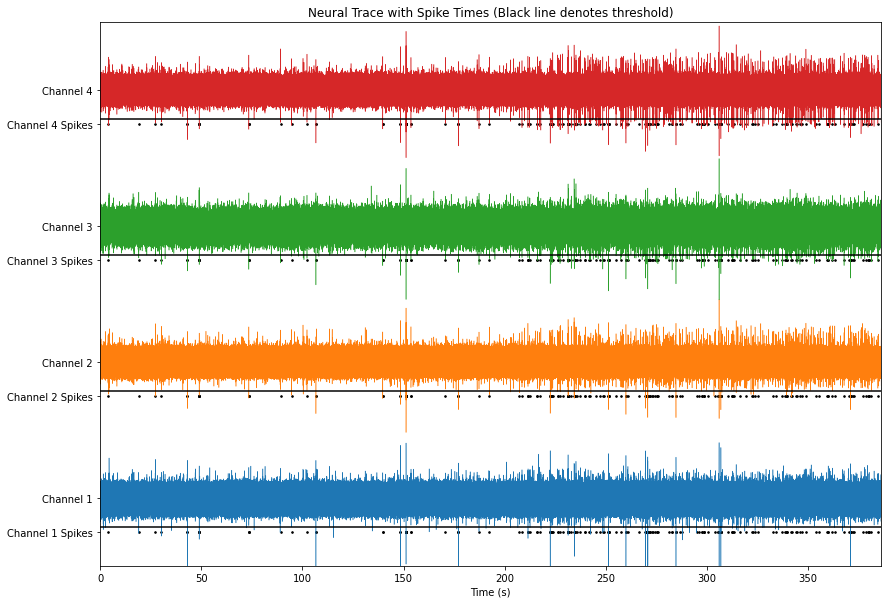

In [108]:
# Plotting raw trace with spike times 

time = np.arange(0, len(dataset[0])) * dt 
fig, ax = plt.subplots(figsize=[14, 10])

for channel in range(len(dataset)):
    ax.plot(time, dataset[channel] + channel*200 ,linewidth=.5)
    ax.scatter(time[resultSamples[channel]], [channel*200 - 50 for i in time[resultSamples[channel]]], color= 'black', marker=".", s = 10)
    plt.axhline(threshold + channel*200, 0, c = 'black')
    
ax.set_ylim(ymin = -100, ymax = 700)
ax.set_xlim(xmin = 0, xmax = len(dataset[0])/Fs)
ax.set_title('Neural Trace with Spike Times (Black line denotes threshold)') 
ax.set_yticks([i*200 - 50 for i in range(len(dataset))] + [i*200 for i in range(len(dataset))])
ax.set_yticklabels(['Channel 1 Spikes', 'Channel 2 Spikes', 'Channel 3 Spikes', 'Channel 4 Spikes',
                    'Channel 1', 'Channel 2', 'Channel 3', 'Channel 4'])
ax.set_xlabel('Time (s)')

plt.savefig('spikeTimes.png')

Next we extract the waveforms segments on all four channels for each spike time.

In [92]:
def extractWaveforms(data, spikeTimes, windowMin = -0.5, windowMax = 0.5, samplingRate = Fs):
    '''
    waveforms = extractWaveforms(..) extracts the waveforms at times s (given in samples) from the 
    filtered signal data using a fixed window (with boundaries set by windowMin and windowMax in ms) 
    around the times of the spikes. The return value is a 3d array of size length(window) x #spikes x #channels.
    '''
    
    waveforms= [[data[channel][int(spike + samplingRate*windowMin/1000):int(spike + samplingRate*windowMax/1000)] \
                   for spike in spikeTimes[channel]] for channel in range(len(data))]
    return waveforms

In [93]:
# Extracting waveforms from data

waveforms = extractWaveforms(dataset, resultSamples, -0.75, 1.25)

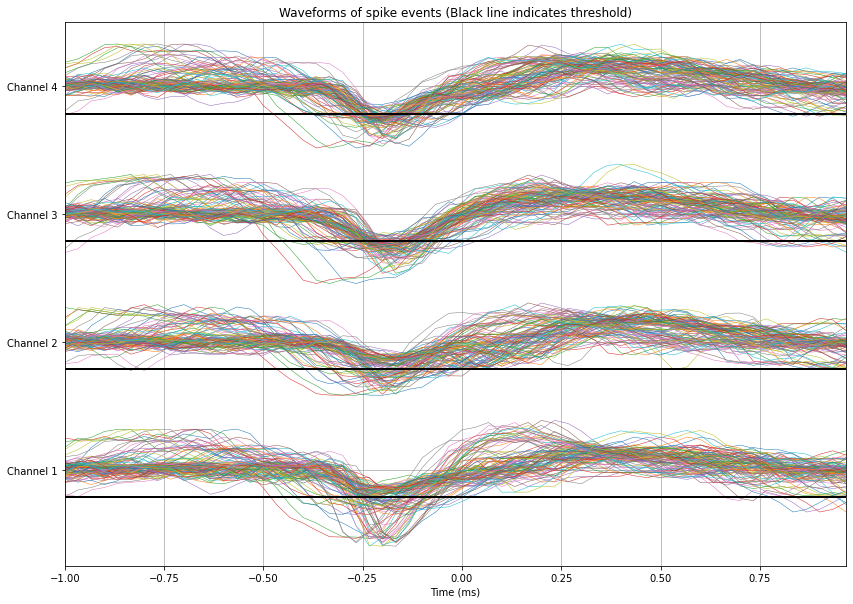

In [94]:
#Plotting first N waveforms

N = 100

time = np.arange(-len(waveforms[0][0])*1000/(2*Fs), len(waveforms[0][0])*1000/(2*Fs), dt * 1000)
fig, ax = plt.subplots(figsize=[14, 10])

for channel in range(len(dataset)):
    for spike in range(min(len(waveforms[channel]), N)):
        ax.plot(time, waveforms[channel][spike] + channel*200 ,linewidth=.5)
        plt.axhline(threshold + channel*200, 0, c = 'black')
        
ax.set_ylim(ymin = -150, ymax = 700)
ax.set_xlim(xmin = time[0], xmax = time[-1])
ax.set_title('Waveforms of spike events (Black line indicates threshold)') 
ax.set_yticks(np.linspace(0, 600, 4))
ax.set_yticklabels(['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4'])
ax.set_xlabel('Time (ms)')
plt.grid()

## Extracting features using PCA

Here our goal is to group spikes into individual neurons based on the “features” that we can define and measure numerically. For example, we can use simple features such as peak-to-peak amplitude, maximum/minimum spike amplitude, and spike width. However these spike features are sensitive to noise and intrinsic variations in spike shapes. Thus we will extract features from our data using Principle Component Analysis (PCA).

PCA is a mathematical technique to project the attributes of the data onto a new coordinate system. The attribute which describes the most variance is called the first principal component (PC), the attribute which stands second in describing variance the second principal component and so on. Thus PCA selects the most important attributes that capture maximum information about the data.

We will compute the first N PCA features on each channel separately. To visualise clusters of features, we will plot scatter plots for all pairwise combinations of 1st PCs.

In [95]:
def extractFeatures(waveforms, components = 3):
    '''
    dataPCA = extractFeatures(..) extracts features for spike sorting from the waveforms, which is a 3d array 
    of size length(window) x #spikes x #channels. The output dataPCA is a matrix of size #spikes x #features.
    
    The implementation does PCA on the waveforms of each channel separately and uses the first three principal 
    components by default. Thus, we get a total of 12 features.
    '''
    
    pca = PCA(n_components = components)
    dataPCA = []
    variance = []
    for channel in waveforms:
        # channel = StandardScaler().fit_transform(channel)
        pca.fit(channel)
        dataPCA.append(pca.transform(channel))
        variance.append(pca.explained_variance_ratio_)
        
    return dataPCA, variance

# Avg variance accounted for by all PCs should be between 70%-80%, so number of PCs must be picked accordingly
def averageVariance(variance):
    return np.mean([sum(variance[channel]) for channel in range(len(variance))])*100

In [96]:
dataPCA, variance = extractFeatures(waveforms, 5)
averageVariance(variance)

76.308110396183

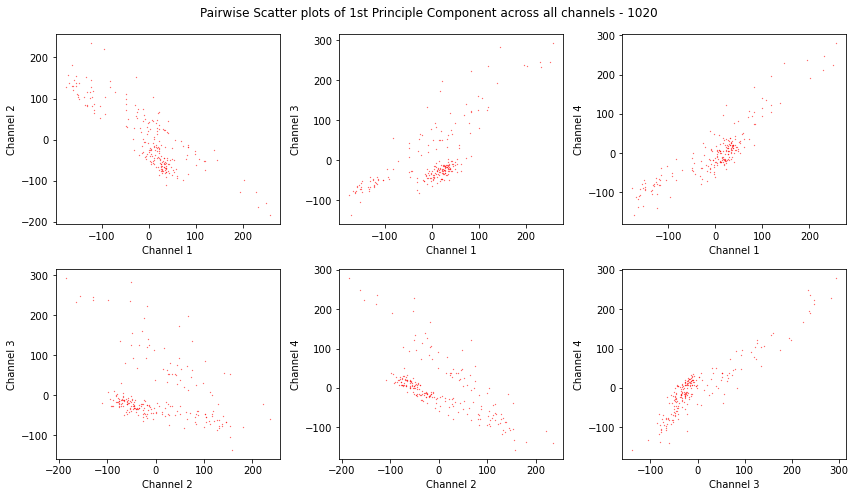

In [97]:
fig, ax = plt.subplots(2, 3, figsize=[12, 7])
    
ax[0][0].plot([row[0] for row in dataPCA[0]], [row[0] for row in dataPCA[1]], 'r.', ms = 0.5)
ax[0][0].set_ylabel('Channel 2')
ax[0][0].set_xlabel('Channel 1')

ax[0][1].plot([row[0] for row in dataPCA[0]], [row[0] for row in dataPCA[2]], 'r.', ms = 0.5)
ax[0][1].set_ylabel('Channel 3')
ax[0][1].set_xlabel('Channel 1')

ax[0][2].plot([row[0] for row in dataPCA[0]], [row[0] for row in dataPCA[3]], 'r.', ms = 0.5)
ax[0][2].set_ylabel('Channel 4')
ax[0][2].set_xlabel('Channel 1')

ax[1][0].plot([row[0] for row in dataPCA[1]], [row[0] for row in dataPCA[2]], 'r.', ms = 0.5)
ax[1][0].set_ylabel('Channel 3')
ax[1][0].set_xlabel('Channel 2')

ax[1][1].plot([row[0] for row in dataPCA[1]], [row[0] for row in dataPCA[3]], 'r.', ms = 0.5)
ax[1][1].set_ylabel('Channel 4')
ax[1][1].set_xlabel('Channel 2')

ax[1][2].plot([row[0] for row in dataPCA[2]], [row[0] for row in dataPCA[3]], 'r.', ms = 0.5)
ax[1][2].set_ylabel('Channel 4')
ax[1][2].set_xlabel('Channel 3')

fig.suptitle("Pairwise Scatter plots of 1st Principle Component across all channels - 1020")
plt.tight_layout()

## Clustering data using GMMs

Here we are clustering the above data using Gaussian Mixture Models (GMMs). 

To find the most appropriate number of clusters in our data, a Bayesian Information Criterion (BIC) is used. In a range of 1 to 20 clusters, the optimum model is one that minimizes the BIC. 

In [98]:
clusterData = np.array([[channel[spike][0] for channel in dataPCA] for spike in range(len(dataPCA[0]))])

mixtureComponents = np.arange(1, 20)
bic = [mixture.GaussianMixture(n_components = component, random_state=0).fit(clusterData).bic(clusterData) for component in mixtureComponents]

C:\Users\adity\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


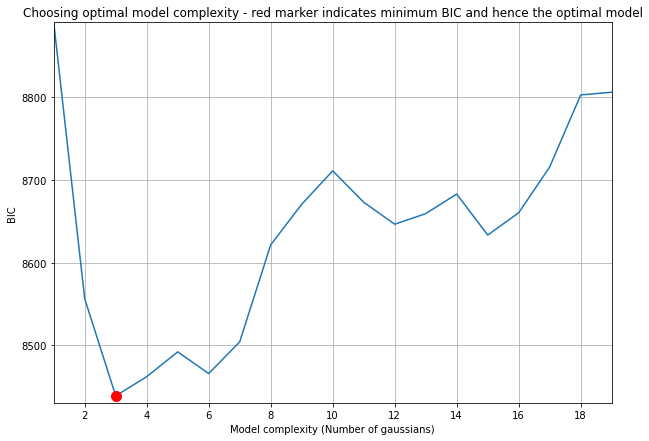

In [99]:
fig, ax = plt.subplots(figsize=[10, 7])

optimumModel = mixtureComponents[np.where(bic == min(bic))[0][0]]
ax.plot(mixtureComponents, bic)
ax.plot(optimumModel, bic[optimumModel-1], 'r.', ms = 20) 
ax.set_ylim(ymin = min(bic)*0.999, ymax = max(bic))
ax.set_xlim(xmin = mixtureComponents[0], xmax = mixtureComponents[-1])
ax.set_title('Choosing optimal model complexity - red marker indicates minimum BIC and hence the optimal model') 
ax.set_xlabel('Model complexity (Number of gaussians)')
ax.set_ylabel('BIC')
plt.grid()

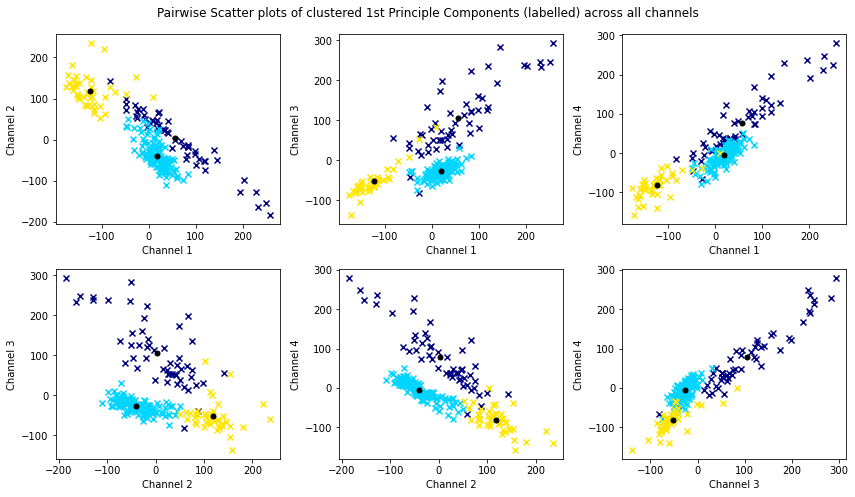

In [100]:
gmm = mixture.GaussianMixture(n_components = optimumModel, random_state=0).fit(clusterData)

fig, ax = plt.subplots(2, 3, figsize=[12, 7])
colors = plt.cm.jet(np.linspace(0, 1, optimumModel + 1))

for i, color in enumerate(colors):
    cluster = clusterData[gmm.predict(clusterData) == i]
    ax[0][0].scatter(cluster[:, 0], cluster[:, 1], color=color, marker="x")
    ax[0][1].scatter(cluster[:, 0], cluster[:, 2], color=color, marker="x")
    ax[0][2].scatter(cluster[:, 0], cluster[:, 3], color=color, marker="x")
    ax[1][0].scatter(cluster[:, 1], cluster[:, 2], color=color, marker="x")
    ax[1][1].scatter(cluster[:, 1], cluster[:, 3], color=color, marker="x")
    ax[1][2].scatter(cluster[:, 2], cluster[:, 3], color=color, marker="x")

ax[0][0].scatter(gmm.means_[:, 0], gmm.means_[:, 1], color= 'black', marker=".", s = 100)      
ax[0][0].set_ylabel('Channel 2')
ax[0][0].set_xlabel('Channel 1')

ax[0][1].scatter(gmm.means_[:, 0], gmm.means_[:, 2], color='black', marker=".", s = 100)
ax[0][1].set_ylabel('Channel 3')
ax[0][1].set_xlabel('Channel 1')

ax[0][2].scatter(gmm.means_[:, 0], gmm.means_[:, 3], color='black', marker=".", s = 100)
ax[0][2].set_ylabel('Channel 4')
ax[0][2].set_xlabel('Channel 1')

ax[1][0].scatter(gmm.means_[:, 1], gmm.means_[:, 2], color='black', marker=".", s = 100)
ax[1][0].set_ylabel('Channel 3')
ax[1][0].set_xlabel('Channel 2')

ax[1][1].scatter(gmm.means_[:, 1], gmm.means_[:, 3], color='black', marker=".", s = 100)
ax[1][1].set_ylabel('Channel 4')
ax[1][1].set_xlabel('Channel 2')

ax[1][2].scatter(gmm.means_[:, 2], gmm.means_[:, 3], color='black', marker=".", s = 100)
ax[1][2].set_ylabel('Channel 4')
ax[1][2].set_xlabel('Channel 3')

fig.suptitle("Pairwise Scatter plots of clustered 1st Principle Components (labelled) across all channels")
plt.tight_layout()

## Verification

### Visual inspection of waveforms

In [101]:
# Extracting waveforms of clusters

clusteredWaveforms = [[np.array(waveforms)[channel][gmm.predict(clusterData) == i] for channel in range(len(waveforms))] for i in range(optimumModel)] 

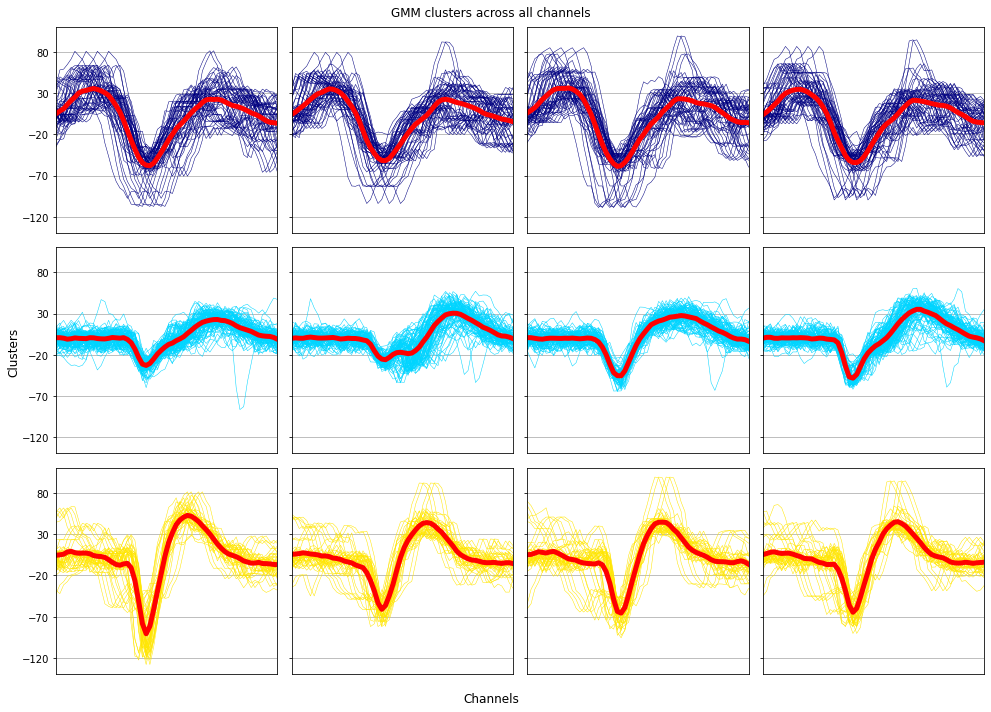

In [102]:
#Plotting 100 waveforms

time = np.arange(-len(waveforms[0][0])*1000/(2*Fs), len(waveforms[0][0])*1000/(2*Fs), dt * 1000)
fig, ax = plt.subplots(len(clusteredWaveforms), len(waveforms), figsize=[14, 10], sharex=True, sharey=True)
colors = plt.cm.jet(np.linspace(0, 1, optimumModel + 1))

for cluster in range(len(clusteredWaveforms)):
    for channel in range(len(clusteredWaveforms[cluster])):
        for spike in range(min(len(clusteredWaveforms[cluster][channel]), 100)):
            ax[cluster][channel].plot(time, clusteredWaveforms[cluster][channel][spike], linewidth=.5, c = colors[cluster])
        meanWaveform = np.mean(clusteredWaveforms[cluster][channel], axis = 0)
        ax[cluster][channel].plot(time, meanWaveform, linewidth=5, c = 'red')
        ax[cluster][channel].set_xlim(xmin = time[0], xmax = time[-1])
        ax[cluster][channel].grid()

plt.setp(ax, xticks=[], yticks = np.linspace(-120, 80, 5))
        
fig.suptitle("GMM clusters across all channels")
fig.supxlabel('Channels')
fig.supylabel('Clusters')
plt.tight_layout()

### Cross-correlation

Neurons have a refractory period: after firing a spike they cannot fire another spike within a period of time. Thus, if multiple cells contribute to one cluster, it won’t have a refractory period. This would appear in the correlogram of spike times between all the clusters.

In [103]:
def correlogram(clusteredSpikes, windowRange = 20):
    '''
    correlatedSpikes = detectSpikes(..) returns the gap between spike times across clusters if spikes occur within
    a default of 20ms within each other. This data will be converted to a histogram later.
    '''
    clusteredSpikes = [[spikeTime*1000 for spikeTime in cluster] for cluster in clusteredSpikes]
    correlatedSpikes = [[[spikes2 - spikes for spikes in cluster for spikes2 in cluster2 if 0 < abs(spikes2 - spikes) < windowRange] 
                         for cluster2 in clusteredSpikes] for cluster in clusteredSpikes]
    
    return correlatedSpikes

In [104]:
clusteredSpikes = [np.array(resultSec)[0][gmm.predict(clusterData) == i] for i in range(optimumModel)]
corr = correlogram(clusteredSpikes)

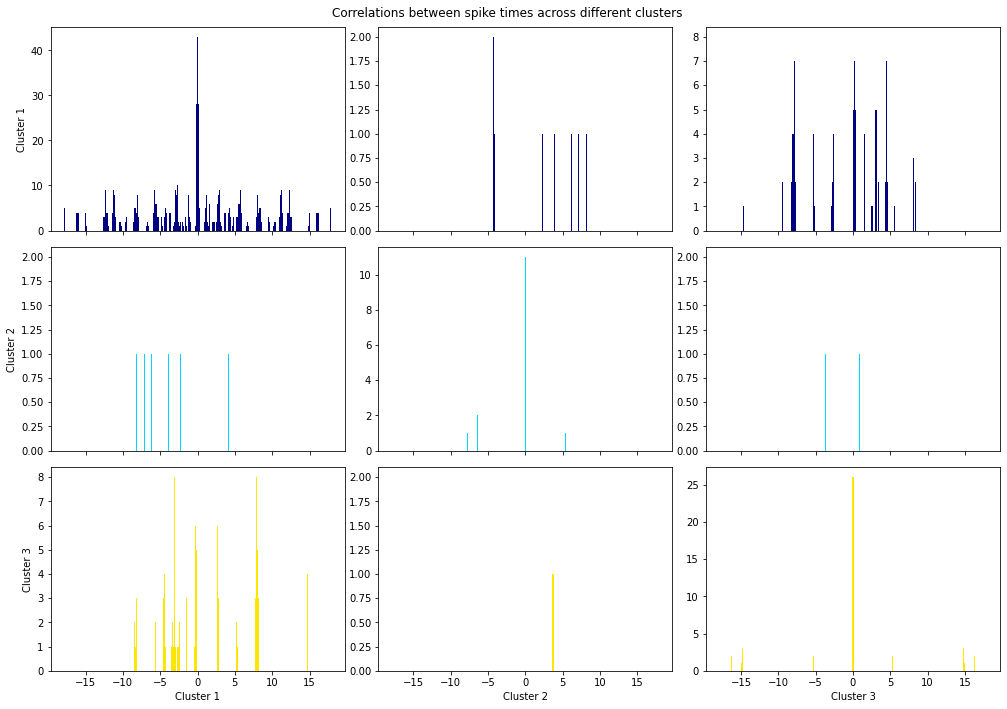

In [106]:
#Plotting correlograms

binSize = 0.1 # in ms

fig, ax = plt.subplots(len(corr[0]), len(corr[1]), figsize=[14, 10], sharex=True)
colors = plt.cm.jet(np.linspace(0, 1, len(corr[0]) + 1))

for clusterx in range(len(corr)):
    for clustery in range(len(corr[cluster])):
            ax[clusterx][clustery].hist(corr[clusterx][clustery], bins = int(40/binSize), 
                                        color = colors[clusterx])
            ax[-1][clustery].set_xlabel('Cluster {}'.format(clustery + 1))
    ax[clusterx][0].set_ylabel('Cluster {}'.format(clusterx + 1))

fig.suptitle("Correlations between spike times across different clusters")
plt.tight_layout()